# Predict sequence variation scores

In [1]:
import torch
import numpy as np
import pandas as pd
import utils
import preprocess
import utils
import data

seq_len = 1024
n_feature = 467
record_pattern = 'sei_seq{}_nip_feature{}'.format(seq_len, n_feature)
model_dir = '../model/{}.model'.format(record_pattern)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

model = torch.load(model_dir).to(device)
model.eval()

Sei(
  (lconv1): Sequential(
    (0): Conv1d(4, 480, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): Conv1d(480, 480, kernel_size=(9,), stride=(1,), padding=(4,))
  )
  (conv1): Sequential(
    (0): Conv1d(480, 480, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): ReLU(inplace=True)
    (2): Conv1d(480, 480, kernel_size=(9,), stride=(1,), padding=(4,))
    (3): ReLU(inplace=True)
  )
  (lconv2): Sequential(
    (0): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (1): Dropout(p=0.2, inplace=False)
    (2): Conv1d(480, 640, kernel_size=(9,), stride=(1,), padding=(4,))
    (3): Conv1d(640, 640, kernel_size=(9,), stride=(1,), padding=(4,))
  )
  (conv2): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv1d(640, 640, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): ReLU(inplace=True)
    (3): Conv1d(640, 640, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): ReLU(inplace=True)
  )
  (lconv3): Sequential(
    (0): MaxPool1d(ke

In [5]:
import os
from tqdm import tqdm
fa_path = '../variation/ricevarmap/falist/'
fa_list = os.listdir(fa_path)
result_path = '../variation/ricevarmap/prediction'

batch_size = 256

for fafile in tqdm(fa_list):
    ref_seq, label = utils.load_data(fa_path + fafile, label=True)
    alt_seq = []
    for i, seq in enumerate(ref_seq):
        ref = label[i][0]
        alt = label[i][2]
        if ref == seq[511]:
            seq = seq[:511]+alt+seq[512:]
            alt_seq.append(seq)

    if len(ref_seq) == len(alt_seq):
        print("Length Checked.")
    else:
        break


    X_ref = preprocess.NucPreprocess(ref_seq).onehot_for_nuc()
    ref_dataset = data.NucDataset(x=X_ref, y=[0]*len(X_ref))
    ref_loader = torch.utils.data.DataLoader(dataset=ref_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    ref_pre = torch.tensor([[0]*n_feature],dtype=torch.float)
    
    with torch.no_grad():
        print('Start ref prediction, total: ', len(X_ref))
        for i, (inputs, _) in enumerate(ref_loader):
            inputs = inputs.to(device, dtype=torch.float)
            inputs = inputs.permute(0,2,1)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            try:
                ref_pre = torch.concat((ref_pre, outputs.to(cpu, dtype=torch.float)))
            except:
                ref_pre = torch.concat((ref_pre, torch.unsqueeze(outputs.to(cpu, dtype=torch.float), dim=0)))
            if i%100 == 0:
                print(i, i/len(ref_loader))
    
    ref_pre = ref_pre[1:].numpy()
    np.save('{}/{}.ref.npy'.format(result_path, fafile), ref_pre)


    X_alt = preprocess.NucPreprocess(alt_seq).onehot_for_nuc()
    alt_dataset = data.NucDataset(x=X_alt, y=[0]*len(X_alt))
    alt_loader = torch.utils.data.DataLoader(dataset=alt_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    alt_pre = torch.tensor([[0]*n_feature],dtype=torch.float)
    
    with torch.no_grad():
        print('Start alt prediction, total: ', len(X_alt))
        for i, (inputs, _) in enumerate(alt_loader):
            inputs = inputs.to(device, dtype=torch.float)
            inputs = inputs.permute(0,2,1)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            try:
                alt_pre = torch.concat((alt_pre, outputs.to(cpu, dtype=torch.float)))
            except:
                alt_pre = torch.concat((alt_pre, torch.unsqueeze(outputs.to(cpu, dtype=torch.float), dim=0)))
            if i%100 == 0:
                print(i, i/len(alt_loader))
    
    alt_pre = alt_pre[1:].numpy()
    np.save('{}/{}.alt.npy'.format(result_path, fafile), alt_pre)

  0%|          | 0/48 [00:00<?, ?it/s]

Length Checked.
Start ref prediction, total:  287410


//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


  2%|▏         | 1/48 [09:47<7:40:03, 587.32s/it]

Length Checked.
Start ref prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


  4%|▍         | 2/48 [19:35<7:30:35, 587.74s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


  6%|▋         | 3/48 [29:24<7:21:24, 588.53s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


  8%|▊         | 4/48 [39:18<7:13:10, 590.70s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 10%|█         | 5/48 [49:14<7:04:31, 592.37s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 12%|█▎        | 6/48 [59:15<6:56:43, 595.31s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 15%|█▍        | 7/48 [1:09:18<6:48:40, 598.05s/it]

Length Checked.
Start ref prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 17%|█▋        | 8/48 [1:19:25<6:40:26, 600.65s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 19%|█▉        | 9/48 [1:29:32<6:31:47, 602.75s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 21%|██        | 10/48 [1:39:36<6:22:02, 603.23s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 23%|██▎       | 11/48 [1:49:40<6:12:03, 603.34s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 25%|██▌       | 12/48 [1:59:43<6:01:59, 603.32s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 27%|██▋       | 13/48 [2:09:51<5:52:45, 604.73s/it]

Length Checked.
Start ref prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 29%|██▉       | 14/48 [2:20:01<5:43:36, 606.37s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 31%|███▏      | 15/48 [2:30:10<5:33:57, 607.19s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 33%|███▎      | 16/48 [2:40:19<5:24:01, 607.55s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 35%|███▌      | 17/48 [2:50:25<5:13:42, 607.19s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 38%|███▊      | 18/48 [3:00:35<5:04:04, 608.15s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 40%|███▉      | 19/48 [3:10:45<4:54:05, 608.48s/it]

Length Checked.
Start ref prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 42%|████▏     | 20/48 [3:20:56<4:44:23, 609.41s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 44%|████▍     | 21/48 [3:31:06<4:34:16, 609.51s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 46%|████▌     | 22/48 [3:41:15<4:24:02, 609.31s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 48%|████▊     | 23/48 [3:51:26<4:14:05, 609.83s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 50%|█████     | 24/48 [4:01:37<4:04:06, 610.26s/it]

Length Checked.
Start ref prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 52%|█████▏    | 25/48 [4:11:47<3:53:52, 610.11s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 54%|█████▍    | 26/48 [4:21:58<3:43:49, 610.44s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 56%|█████▋    | 27/48 [4:32:09<3:33:42, 610.60s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 58%|█████▊    | 28/48 [4:42:16<3:23:10, 609.55s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 60%|██████    | 29/48 [4:52:26<3:13:01, 609.57s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 62%|██████▎   | 30/48 [5:02:40<3:03:14, 610.82s/it]

Length Checked.
Start ref prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 65%|██████▍   | 31/48 [5:12:48<2:52:50, 610.05s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 67%|██████▋   | 32/48 [5:22:58<2:42:43, 610.19s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 69%|██████▉   | 33/48 [5:33:07<2:32:25, 609.67s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 71%|███████   | 34/48 [5:43:16<2:22:13, 609.52s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 73%|███████▎  | 35/48 [5:53:25<2:12:02, 609.44s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 75%|███████▌  | 36/48 [6:03:36<2:01:57, 609.75s/it]

Length Checked.
Start ref prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 77%|███████▋  | 37/48 [6:13:47<1:51:53, 610.31s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 79%|███████▉  | 38/48 [6:24:00<1:41:51, 611.15s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 81%|████████▏ | 39/48 [6:34:13<1:31:44, 611.66s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 83%|████████▎ | 40/48 [6:44:22<1:21:27, 610.90s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 85%|████████▌ | 41/48 [6:54:32<1:11:14, 610.62s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 88%|████████▊ | 42/48 [7:04:43<1:01:04, 610.69s/it]

Length Checked.
Start ref prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287409
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 90%|████████▉ | 43/48 [7:14:52<50:49, 609.99s/it]  

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 92%|█████████▏| 44/48 [7:25:04<40:42, 610.69s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 94%|█████████▍| 45/48 [7:35:15<30:32, 610.86s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 96%|█████████▌| 46/48 [7:45:24<20:20, 610.23s/it]

Length Checked.
Start ref prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278
Start alt prediction, total:  287410
0 0.0
100 0.08904719501335707
200 0.17809439002671415
300 0.26714158504007124
400 0.3561887800534283
500 0.4452359750667854
600 0.5342831700801425
700 0.6233303650934996
800 0.7123775601068566
900 0.8014247551202137
1000 0.8904719501335708
1100 0.9795191451469278


 98%|█████████▊| 47/48 [7:55:32<10:09, 609.64s/it]

Length Checked.
Start ref prediction, total:  125176
0 0.0
100 0.20449897750511248
200 0.40899795501022496
300 0.6134969325153374
400 0.8179959100204499
Start alt prediction, total:  125176
0 0.0
100 0.20449897750511248
200 0.40899795501022496
300 0.6134969325153374
400 0.8179959100204499


100%|██████████| 48/48 [7:59:43<00:00, 599.66s/it]


# Calculate constrain and draw plot

In [50]:
import glob
import numpy as np
import pandas as pd
import re
import os

seq_len = 1024
n_feature = 467
record_pattern = 'sei_seq{}_nip_feature{}'.format(seq_len, n_feature)
result_path = '../variation/ricevarmap/prediction'

def sc_projection(chromatin_profile_preds, clustervfeat):
    return np.dot(chromatin_profile_preds, clustervfeat.T)

ordered_profiles = np.load('../prediction/{}.cluster_ordered_profiles.npy'.format(record_pattern))

file_list = ['{}/{:02d}.fa.ref.npy'.format(result_path, i) for i in range(0,len(os.listdir(result_path))//2)]

tnrefprojs = []
tnaltprojs = []
for f in file_list:
    a = sc_projection(np.load(f), ordered_profiles)[:,:33].astype(np.float32)
    tnrefprojs.append(a)
    b = sc_projection(np.load(f.replace('ref','alt')), ordered_profiles)[:,:33].astype(np.float32)
    tnaltprojs.append(b)
tnrefprojs=np.vstack(tnrefprojs)
tnaltprojs=np.vstack(tnaltprojs)


tvcfs = pd.read_csv('../variation/ricevarmap/rice4k_geno.vcf_k20nearest.bed', header=None, sep="\t")

tleiden = []
for rec in tvcfs[6].values:
    try:
        tleiden.append(int(rec.replace('cluster','')))
    except:
        tleiden.append(np.nan)
tleiden = np.array(tleiden)

cname_res = []
c_def = np.load('../visualization/sei_seq1024_nip_feature467.cluster_def.npy', allow_pickle=True).item()['definition']
for clu in c_def:
    rec = c_def[clu]
    ID = rec.split(' ')[0]
    name = ' '.join(rec.split(' ')[1:])
    group = re.sub(r'[0-9]+', '', ID)
    cname_res.append({'ID':ID, 'name':name, 'index': int(clu.replace('cluster','')), 'group': group})

cnames = pd.DataFrame(cname_res)
cnames = cnames.iloc[np.argsort(cnames['index']),:]

In [51]:
from scipy.stats import sem

cymeans=[]
cysems=[]
cyseps = []
cNs = []


for i in range(33):
    i = [i]
    ind = np.isin(tleiden,i)


    diffproj = tnaltprojs[:,np.array(i)][ind,:] - tnrefprojs[:,np.array(i)][ind,:]
    diffproj = diffproj.mean(axis=1)

    ysep = np.concatenate([np.quantile(diffproj[diffproj<0],[0.01,0.1]),[0], \
                            np.quantile(diffproj[diffproj>0],[0.9,0.99])])


    ymean=[]
    ysem = []
    Ns = []
    label =  tvcfs[5].values[ind] > 0.01 


    bins = pd.cut(diffproj,np.concatenate([[float('-Inf')],ysep,[float('Inf')]]) , labels=False)

    for j in range(len(ysep)+1):
        ymean.append(np.nanmean(label[bins==j]))
        ysem.append(sem(label[bins==j],nan_policy='omit'))
        Ns.append(np.nansum(bins==j))
        
    cymeans.append(ymean)
    cysems.append(ysem)
    cyseps.append(ysep)
    cNs.append(Ns)

In [3]:
pd.DataFrame({'mean': np.concatenate(cymeans),
              'sem': np.concatenate(cysems),
              'Bin': np.tile(np.arange(6),33),
             'C': np.repeat(np.arange(33),6)}).to_csv('../variation/ricevarmap/MAFcommon0.01.1000g_pure_Jap.tsv',sep='\t')

In [26]:
tvcfs[tvcfs[5]>0.01]

,0,1,2,3,4,5,6
4,1,1061,2085,C,T,0.053322,cluster2
5,1,1067,2091,G,A,0.081253,cluster2
18,1,1183,2207,C,T,0.180279,cluster0
21,1,1196,2220,C,T,0.234709,cluster0
22,1,1197,2221,C,T,0.014600,cluster0
...,...,...,...,...,...,...,...
13633432,12,27529601,27530625,A,T,0.032797,cluster0
13633433,12,27529614,27530638,A,G,0.648752,cluster0
13633434,12,27529621,27530645,A,G,0.648328,cluster0
13633435,12,27529688,27530712,C,T,0.024762,cluster0


In [52]:
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from scipy import stats


mean_y = []
for i in range(33):
    ind = tleiden==i
    diffproj = tnaltprojs[:,i][ind] - tnrefprojs[:,i][ind]
    label = tvcfs[5].values[ind] > 0.01
    mean_y.append(np.mean(label))


    
npv = []
nt  = []
ncoef = []
ncoef_se = []
nmean_y = []
for i in range(33):

    ind = tleiden==i
    diffproj = tnaltprojs[:,i][ind] - tnrefprojs[:,i][ind] 
    diffproj /= np.std(diffproj)
    
    filtered = diffproj<0
    label = tvcfs[5].values[ind] > 0.01

    X2 = sm.add_constant(np.abs(diffproj[filtered,None]))
    est = Logit(label[filtered], X2)
    est2 = est.fit()
    
    npv.append(est2.pvalues[1])
    ncoef.append(est2.params[1])
    ncoef_se.append(est2.bse[1])
    nt.append(est2.tvalues[1])
    nmean_y.append(np.mean(label))


ppv = []
pt  = []
pcoef = []
pcoef_se = []
pmean_y = []
for i in range(33):
    ind = tleiden==i
    diffproj = tnaltprojs[:,i][ind] - tnrefprojs[:,i][ind]
    diffproj /= np.std(diffproj)
    
    filtered = diffproj>0
    label = tvcfs[5].values[ind] > 0.01


    X2 = sm.add_constant(np.abs(diffproj[filtered,None]))
    est = Logit(label[filtered], X2)
    est2 = est.fit()
    ppv.append(est2.pvalues[1])
    pcoef.append(est2.params[1])
    pcoef_se.append(est2.bse[1])
    pt.append(est2.tvalues[1])
    pmean_y.append(np.mean(label))

Optimization terminated successfully.
         Current function value: 0.656820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648618
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.651251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692552
  

In [54]:
from statsmodels.stats.multitest import multipletests 
def onesided(twosidedps, ts):
    return [p/2 if t<0 else 1-p/2  for p,t in zip(twosidedps,ts)]

fdr = np.fmax(multipletests(onesided(npv, nt), method='fdr_bh')[1],
        multipletests(onesided(ppv, pt), method='fdr_bh')[1])

Saving 8 x 8 in image


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps 



In addition: Warning messages:
1: `legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing` 
2: ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps 


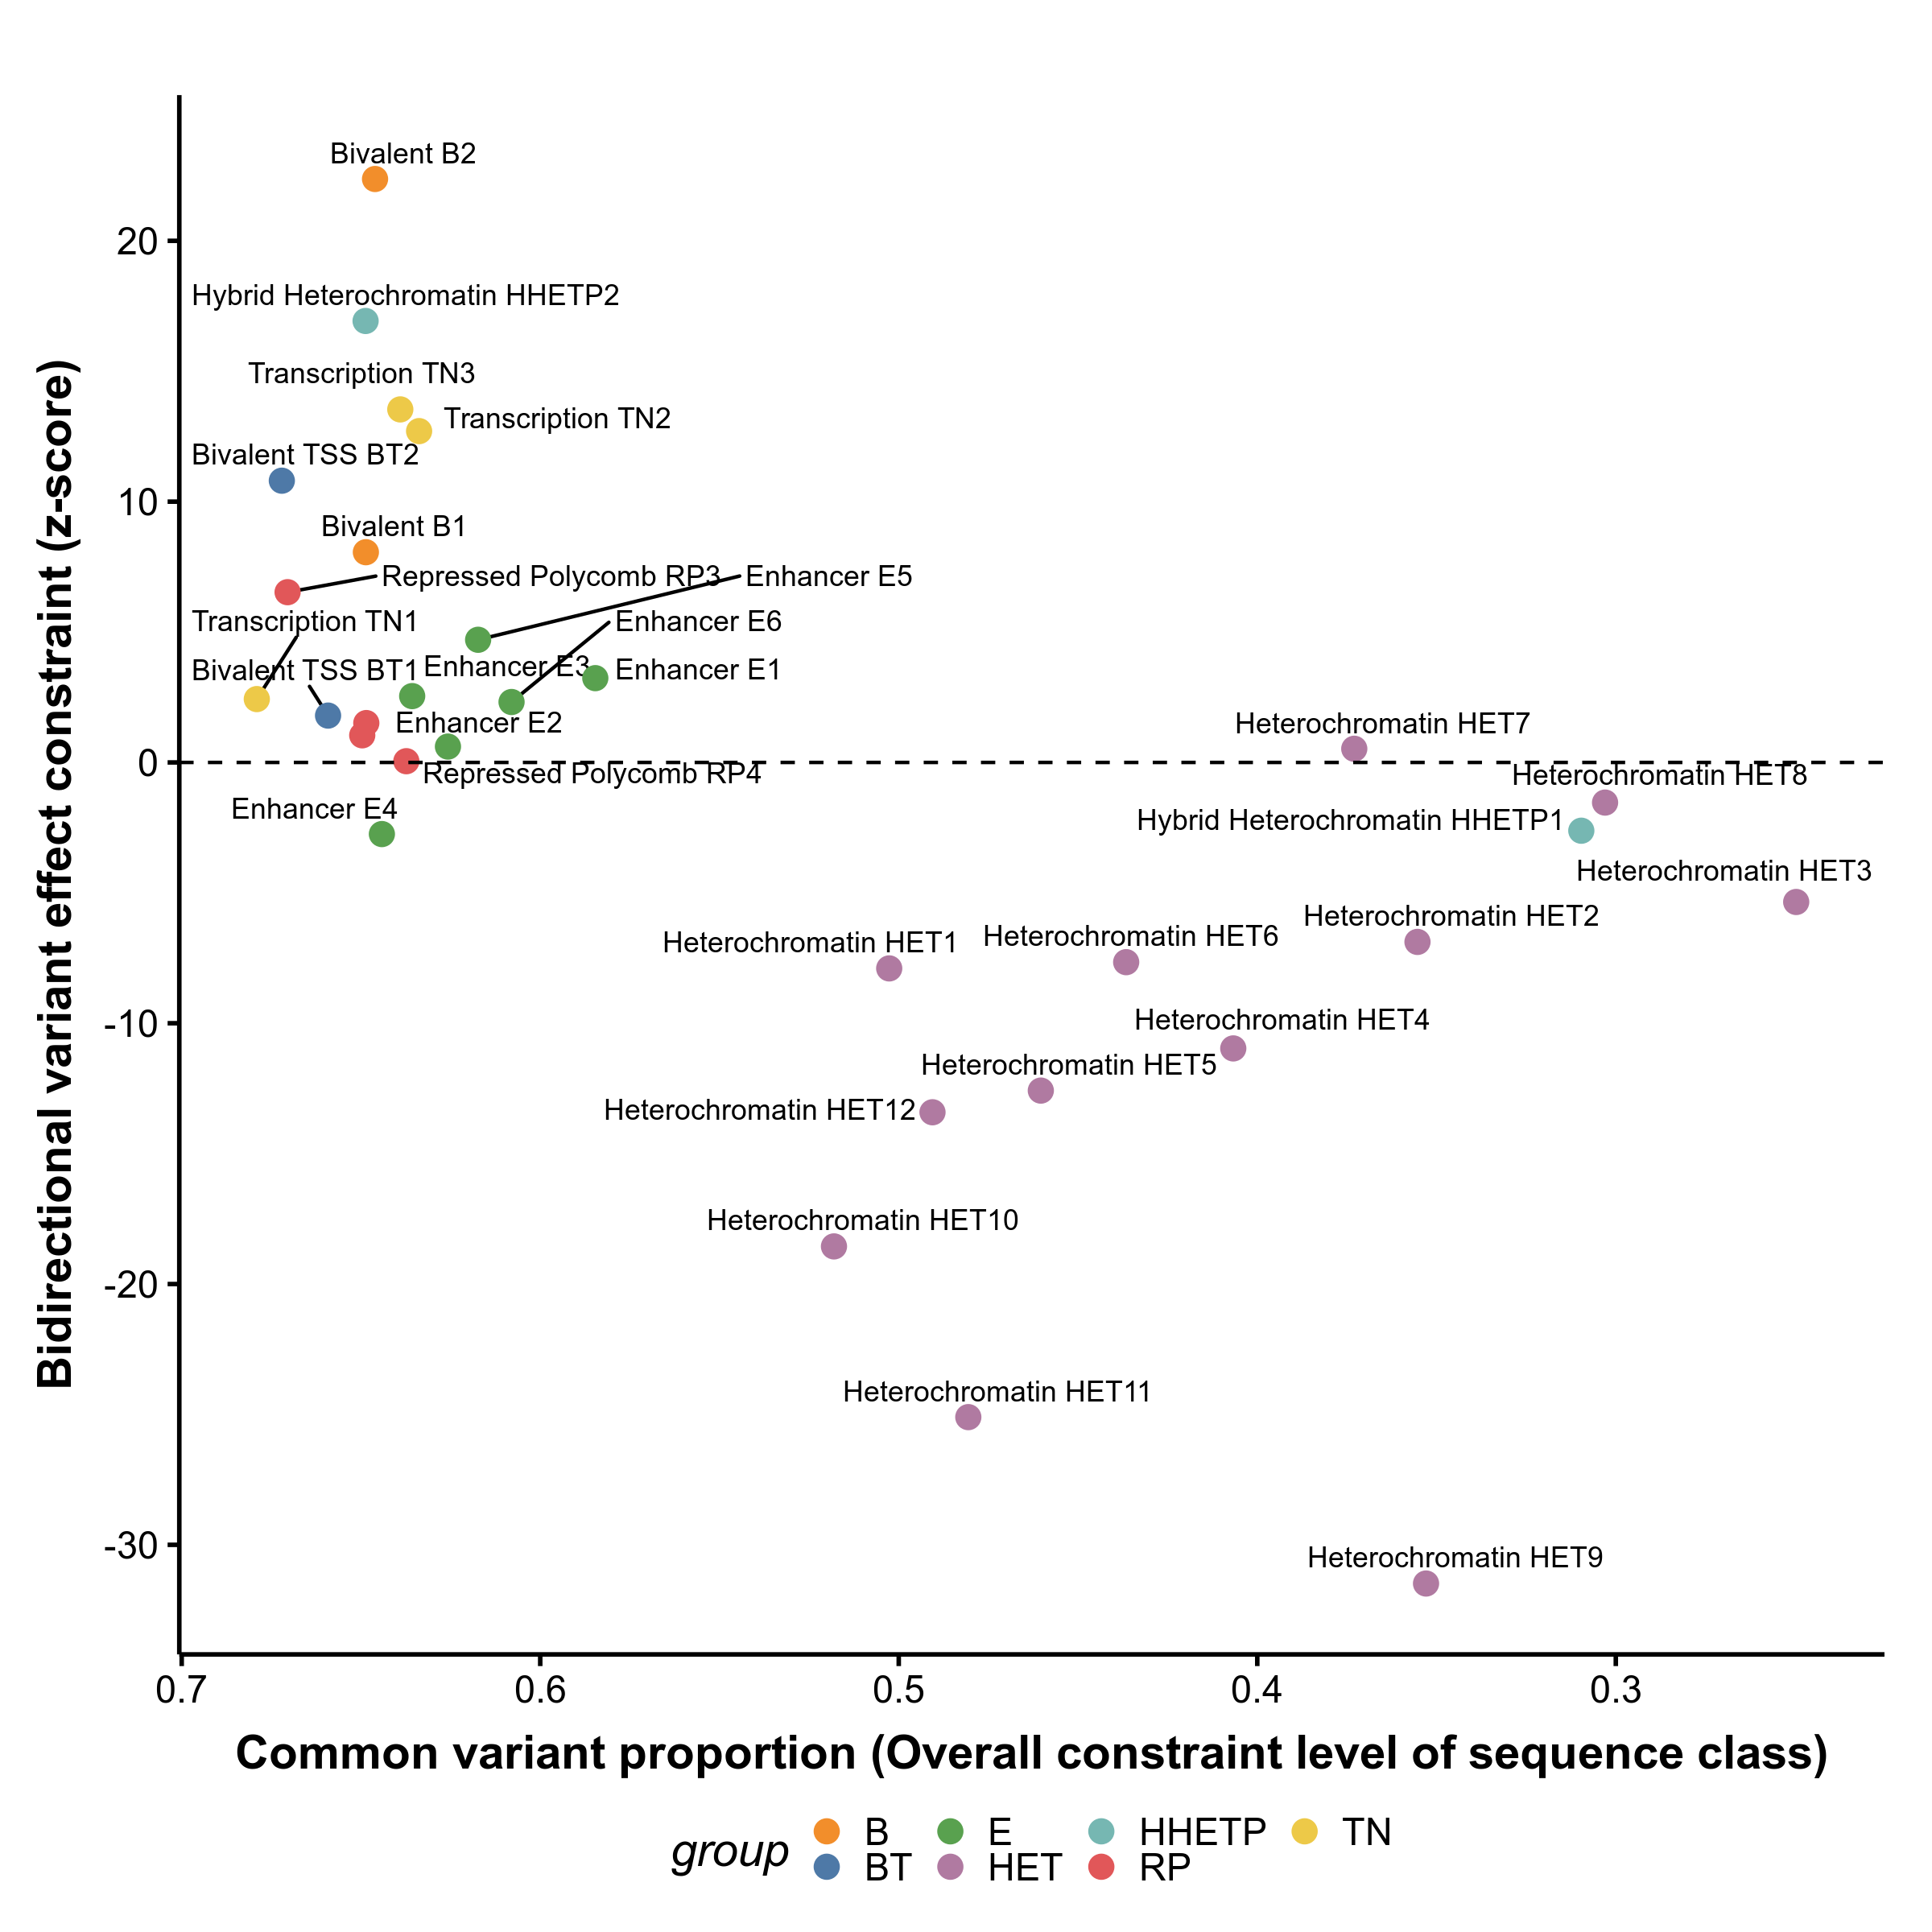

In [55]:
%%R -i cnames,mean_y,pt,nt,pcoef,ncoef,pcoef_se,ncoef_se,pmean_y,nmean_y,mean_y,fdr -w 8 -h 8 --units in -r 300

require(ggplot2)
require(ggrepel)
require(data.table)
#cnames$group = gsub('[0-9]*','',cnames$label)
cnames$group = factor(cnames$group,levels= c('B', 'BT', 'E', 'HET', 'HHETP', 'L', 'RP', 'TN'))

theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

z_score = -(unlist(pcoef)/unlist(pcoef_se)+unlist(ncoef)/unlist(ncoef_se))/sqrt(2)


plotdata = data.table(x =  unlist(mean_y), y= z_score, 
                    label = paste(cnames$name, cnames$ID),
                     group = cnames$group)
p = ggplot(plotdata[group!='L',])+geom_text_repel(aes(x= x, y = y, 
                             label=label),size=I(3),
                        nudge_x=0.003,nudge_y=0.5,max.time=6,max.iter=60000)+
    geom_point(aes(x= x, y =  y,  
                   color=group),size=I(3))+
    #geom_vline(xintercept=0.157100,linetype=2)+
    geom_hline(yintercept=0,linetype=2)+
    theme_Publication()+scale_x_reverse()+
    scale_color_manual(values=c("#F28E2B","#4E79A7","#59A14F","#B07AA1","#76B7B2","#E15759","#EDC948"))+
    ylab('Bidirectional variant effect constraint (z-score)')+
xlab('Common variant proportion (Overall constraint level of sequence class)')

ggsave('../figures/evo.ricevarmap.pure_Jap.pdf',device=cairo_pdf)


p

# Test variation

In [3]:
import glob
import numpy as np
import pandas as pd
import re
import os
from tqdm import tqdm

seq_len = 1024
n_feature = 467
record_pattern = 'sei_seq{}_nip_feature{}'.format(seq_len, n_feature)
result_path = '../variation/ricevarmap/prediction'

def sc_projection(chromatin_profile_preds, clustervfeat):
    return np.dot(chromatin_profile_preds, clustervfeat.T)

ordered_profiles = np.load('../prediction/{}.cluster_ordered_profiles.npy'.format(record_pattern))

file_list = ['{}/{:02d}.fa.ref.npy'.format(result_path, i) for i in range(0,len(os.listdir(result_path))//2)]

tnref = []
tnrefprojs = []
tnalt = []
tnaltprojs = []
for f in tqdm(file_list):
    ref = np.load(f)
    a = sc_projection(ref, ordered_profiles)[:,:33].astype(np.float32)
    tnref.append(ref)
    tnrefprojs.append(a)
    alt = np.load(f.replace('ref','alt'))
    b = sc_projection(alt, ordered_profiles)[:,:33].astype(np.float32)
    tnalt.append(alt)
    tnaltprojs.append(b)
tnrefprojs=np.vstack(tnrefprojs)
tnaltprojs=np.vstack(tnaltprojs)

tnref = np.vstack(tnref)
tnalt = np.vstack(tnalt)

tvcfs = pd.read_csv('../variation/ricevarmap/rice4k_geno.vcf_filtered_clustered.bed', header=None, sep="\t")

100%|██████████| 48/48 [10:19<00:00, 12.90s/it]


In [11]:
variation_score = np.sum(np.abs(tnaltprojs-tnrefprojs), axis=1)

In [21]:
ve_sorted_vcfs = tvcfs.iloc[variation_score.argsort()]
ve_sorted_vcfs.to_csv('../variation/ricevarmap/variation_abse_rice4k_geno_filtered_clustered.bed',sep="\t", header=None, index=False)

In [19]:
sorted_df = tvcfs.iloc[variation_score.argsort()]

,0,1,2,3,4,5,6,7
10169023,10,2270199,2271223,T,C,0.513846,cluster9,137
11337656,11,9543490,9544514,T,A,0.001302,cluster24,62
7275337,7,11202768,11203792,G,A,0.052445,cluster15,176
5775746,6,2305652,2306676,A,T,0.001086,cluster19,12
4166793,4,14563383,14564407,C,T,0.006269,cluster8,73
...,...,...,...,...,...,...,...,...
8176237,8,5720025,5721049,A,C,0.015466,cluster2,167
3399596,4,902619,903643,G,A,0.146509,cluster7,165
6235645,6,14379501,14380525,G,T,0.019085,cluster3,147
5635836,5,27133026,27134050,C,T,0.001612,cluster24,30


In [4]:
raw_vari_eff_mat = tnalt - tnref

In [5]:
df = pd.DataFrame(raw_vari_eff_mat)
df.to_csv('../variation/ricevarmap/vari_eff_raw.tsv', sep="\t", index=False, header=None)